# Población dependiente de la agricultura
- **[Data source](https://www.ine.es/jaxiT3/Tabla.htm?t=3994)**

# Setup
## Library import
We import all the required Python libraries

In [8]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Data import

### Población activa
**Read data**

In [2]:
df = pd.read_csv(f'../../datasets/raw/other/población_dependiente_de_agricultura.csv',sep=";", error_bad_lines=False)
# Drop columns
df.drop(columns=['Sector econ�mico', 'Periodo'], inplace=True)

# Remove Canarias, Ceuta, and Melilla
df = df[~df['Provincias'].isin(['35 Palmas, Las', '38 Santa Cruz de Tenerife', '51 Ceuta', '52 Melilla'])]

# From str to float
df['Total'] = df['Total'].apply(lambda x: x.replace(',', '.'))
df = df.astype({'Total': float})

# Mean of the year  
df = df.groupby(['Provincias']).mean()
df = df.reset_index()
df['year'] = 2020

# Get province id
df['CO_PROVINC'] = df['Provincias'].apply(lambda x: x.split(' ')[0])
df = df.astype({'CO_PROVINC': int})
df.drop(columns='Provincias', inplace=True)
df.rename(columns={'Total': 'value'}, inplace=True)

df.head()

,value,year,CO_PROVINC
0,1.800,2020,1
1,8.600,2020,2
2,2.000,2020,3
3,21.375,2020,4
4,9.275,2020,5


### Comarcas Agrarias 
**Read data** 

In [3]:
comarcas_agr = gpd.read_file(f'../../datasets/raw/georegions/ComarcasAgrarias/ComarcasAgrarias.shp')
comarcas_agr.sort_values(['CO_CCAA', 'CO_PROVINC', 'CO_COMARCA'], inplace = True)

# Remove Canarias, Ceuta, and Melilla
comarcas_agr = comarcas_agr[~comarcas_agr['DS_CCAA'].isin(['Canarias', 'Ceuta', 'Melilla'])]
comarcas_agr = comarcas_agr.reset_index(drop=True)
comarcas_agr.drop(columns=['CO_COMARCA', 'DS_COMARCA'], inplace=True)
comarcas_agr

,CO_CCAA,DS_CCAA,CO_PROVINC,DS_PROVINC,geometry
0,1,Andalucía,4,Almeria,"POLYGON ((-2.18190 37.89882, -2.17200 37.88869..."
1,1,Andalucía,4,Almeria,"POLYGON ((-2.30698 37.55521, -2.30604 37.55513..."
2,1,Andalucía,4,Almeria,"MULTIPOLYGON (((-1.90983 37.53787, -1.87940 37..."
3,1,Andalucía,4,Almeria,"POLYGON ((-2.82541 37.27830, -2.82478 37.27825..."
4,1,Andalucía,4,Almeria,"POLYGON ((-2.07134 37.29541, -2.07096 37.29533..."
...,...,...,...,...,...
341,17,Comunidad Valenciana,46,Valencia,"POLYGON ((-0.23569 39.10358, -0.23488 39.10342..."
342,17,Comunidad Valenciana,46,Valencia,"POLYGON ((-1.05911 39.31525, -1.04755 39.30510..."
343,17,Comunidad Valenciana,46,Valencia,"POLYGON ((-0.77926 39.26022, -0.77850 39.25927..."
344,17,Comunidad Valenciana,46,Valencia,"MULTIPOLYGON (((-0.55119 39.00634, -0.55038 39..."


**Dissolve geometries into provinces**

In [5]:
provincias = gpd.GeoDataFrame(columns=list(comarcas_agr.columns))
for provincia in comarcas_agr.DS_PROVINC.unique():
    gdf_tmp = comarcas_agr[comarcas_agr['DS_PROVINC'] == provincia]
    gdf_tmp = gdf_tmp.dissolve()
    
    provincias = pd.concat([provincias, gdf_tmp[list(comarcas_agr.columns)]])

**Save provincias**

In [20]:
provincias.to_file(f'../../datasets/raw/georegions/Provincias/Provincias.shp')

### Merge data with provinces

In [6]:
gdf = pd.merge(provincias, df, how='left', on='CO_PROVINC' )
gdf.head()

,CO_CCAA,DS_CCAA,CO_PROVINC,DS_PROVINC,geometry,value,year
0,1,Andalucía,4,Almeria,"MULTIPOLYGON (((-3.03139 35.94165, -3.03124 35...",21.375,2020
1,1,Andalucía,11,Cádiz,"MULTIPOLYGON (((-5.29471 36.24562, -5.29486 36...",3.675,2020
2,1,Andalucía,14,Córdoba,"MULTIPOLYGON (((-5.12971 37.69875, -5.12903 37...",13.775,2020
3,1,Andalucía,18,Granada,"MULTIPOLYGON (((-3.38971 36.70813, -3.38988 36...",11.700,2020
4,1,Andalucía,21,Huelva,"MULTIPOLYGON (((-6.38457 37.33749, -6.38402 37...",18.950,2020


**Display data**

Text(0.5, 1.0, 'Población dependiente de agricultura')

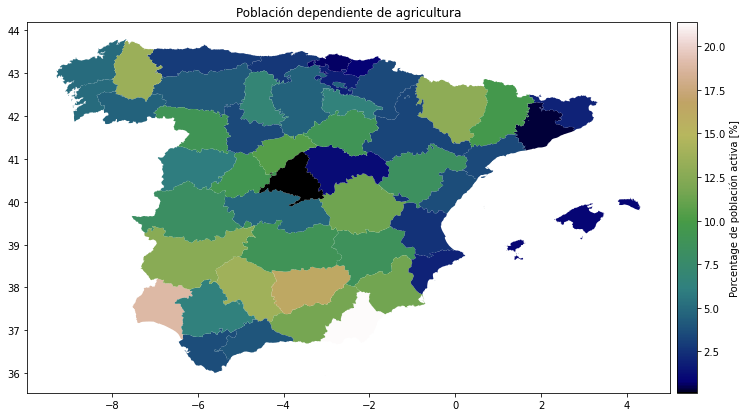

In [9]:
fig, ax = plt.subplots(1,1,figsize=(12, 12))


divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="3%", pad=0.1) 

gdf.plot(ax=ax, column='value', cmap='gist_earth', legend=True, cax=cax, legend_kwds={'label': 'Porcentage de población activa [%]'})
ax.set_title('Población dependiente de agricultura')

**Reorganice data**

In [10]:
gdf.columns

Index(['CO_CCAA', 'DS_CCAA', 'CO_PROVINC', 'DS_PROVINC', 'geometry', 'value',
       'year'],
      dtype='object')

In [16]:
df = gdf.drop(columns='geometry')
df['dataset'] = 'Población activa'
df['indicator'] = 'Porcentage población activa en la agricultura'
df['unit'] = '%' 
df = df [['CO_CCAA', 'CO_PROVINC', 'dataset', 'indicator', 'value', 'year', 'unit']]
df.head()

,CO_CCAA,CO_PROVINC,dataset,indicator,value,year,unit
0,1,4,Población activa,Porcentage población activa en la agricultura,21.375,2020,%
1,1,11,Población activa,Porcentage población activa en la agricultura,3.675,2020,%
2,1,14,Población activa,Porcentage población activa en la agricultura,13.775,2020,%
3,1,18,Población activa,Porcentage población activa en la agricultura,11.700,2020,%
4,1,21,Población activa,Porcentage población activa en la agricultura,18.950,2020,%


**Save tables**

In [17]:
df.to_csv(f'../../datasets/processed/población_activa.csv', index = False)